# Imports, config and setting global variables

In [530]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm
tqdm.pandas()

from sklearn.datasets import fetch_california_housing, load_diabetes

In [504]:
import logging

if not os.path.exists('logs'):
    os.makedirs('logs')

LOGGING_FILE = os.path.join('logs', 'experiments.log')

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', 
                    datefmt='%Y-%m-%d %H:%M:%S', 
                    handlers=[logging.StreamHandler(), 
                              logging.FileHandler(LOGGING_FILE)])


In [543]:
N_SAMPLES = 10_000

MIN_LAMBDA_LOG_10 = -6
MAX_LAMBDA_LOG_10 = 6
NUM_LAMBDAS = 50

logging.info(f'Generating {N_SAMPLES} samples')
logging.info(f'''Using {NUM_LAMBDAS} lambdas equally spaced in log space from 10^({MIN_LAMBDA_LOG_10}) to 10^{MAX_LAMBDA_LOG_10}''')

LAMBDAS = np.logspace(MIN_LAMBDA_LOG_10, MAX_LAMBDA_LOG_10, NUM_LAMBDAS)

DGP_OPTIONS = ["3x_1 - 2x_2", "optim_slides", "california_housing", "diabetes", ]

DGP = DGP_OPTIONS[2]

# DGP1
MIN_THETA = -5
MAX_THETA = 5
N_VALUES_FOR_EACH_THETA = 10

# DGP 2
CORR_AMOUNT = 0.99

2024-12-08 02:30:53 - INFO - Generating 10000 samples
2024-12-08 02:30:53 - INFO - Using 50 lambdas equally spaced in log space from 10^(-6) to 10^6


## Helper functions

In [544]:
def empirical_risk(X, y, theta):
    # In the slides we don't divide by num samples, but it did not matter
    return np.mean((y - X @ theta)**2)


In [545]:
def filter_lambda_closest(df, target_lambda):
    """Filter the dataframe to the row with the lambda closest to the target_lambda
    
    We need this for replicating slide 327 (theta getting pulled to the origin)
    """
    
    closest_row = df.iloc[(df['lambda'] - target_lambda).abs().argsort()[:1]]
    return closest_row

In [546]:
def get_tuplet_structure(param, n_features):
    """Used for DGP from Optimization slides
    
    param = 0 -> identity matrix (no correlation)
    param = 1 -> all ones matrix (full correlation)
    """
    return np.array([[param**(abs(i-j)) for j in range(n_features)] for i in range(n_features)])


# Defining Data Generating Processes 

- DGP from slide 327

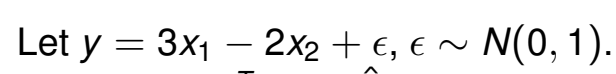

- DGP stolen from optimization lecture
  
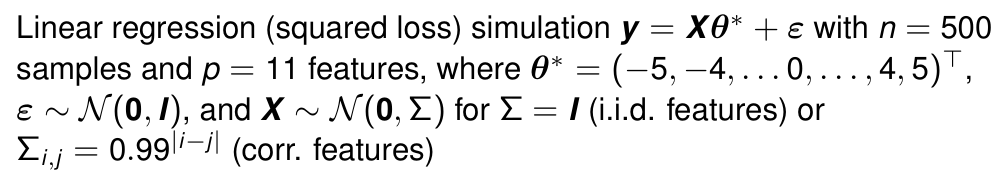



In [547]:
def data_generation_process(option):
    assert option in DGP_OPTIONS, f"Option {option} not in {DGP_OPTIONS}"
    
    match option:
        # (Slide 327/337) y = 3x_1 - 2x_2 + epsilon. epsilon ~ N(0, 1)
        case "3x_1 - 2x_2":
            X = np.random.rand(N_SAMPLES, 2)
            theta_true = np.array([3, -2]).reshape(-1, 1)
            y = X @ theta_true + np.random.randn(N_SAMPLES).reshape(-1,1)
            
        # Slide 1 from https://moodle.lmu.de/pluginfile.php/2688743/mod_folder/content/0/slides-multivar-first-order-12-comparison.pdf?forcedownload=1
        case "optim_slides":
            theta_true = np.arange(-5, 5+1, 1).reshape(-1, 1)
            N_FEATURES = len(theta_true)

            cov_matrix = get_tuplet_structure(CORR_AMOUNT, N_FEATURES)
            X = np.random.multivariate_normal(mean=np.zeros(N_FEATURES), cov=cov_matrix, size=N_SAMPLES) #for _ in range(N_SAMPLES)
            y = X @ theta_true + np.random.randn(N_SAMPLES).reshape(-1,1)
            
        case "california_housing":
            # https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.fetch_california_housing.html
            data = fetch_california_housing()
            X = data.data
            y = data.target.reshape(-1, 1)
            theta_true = None
    
        case "diabetes":
            # https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_diabetes.html
            data = load_diabetes()
            X = data.data
            y = data.target.reshape(-1, 1)
            theta_true = None
     
    return X, y, theta_true

In [548]:
X, y, theta_true = data_generation_process(DGP_OPTIONS[2])
X.shape, y.shape#, theta_true.shape

((20640, 8), (20640, 1))

# Contour plots

### Contours of the unregularized loss function

In [549]:
if X.shape[1] != 2:
    raise ValueError("Can't plot, skip this section")

ValueError: Can't plot, skip this section

In [550]:
theta_1_vals = np.linspace(MIN_THETA, MAX_THETA, N_VALUES_FOR_EACH_THETA)
theta_2_vals = np.linspace(MIN_THETA, MAX_THETA, N_VALUES_FOR_EACH_THETA)

theta_pairs = np.array(np.meshgrid(theta_1_vals, theta_2_vals)).T.reshape(-1, 2)


df_unreg_risk = pd.DataFrame(theta_pairs, columns=['theta_1', 'theta_2'])

In [551]:
df_unreg_risk["emp_risk"] = df_unreg_risk[['theta_1', 'theta_2']].progress_apply(lambda thetas:
    empirical_risk(X, y, thetas), axis=1)

  1%|          | 1/100 [00:00<?, ?it/s]


Exception: Dot product shape mismatch, (2,) vs (8, 20640)

In [ ]:
fig_cont_plot = go.Figure(data=go.Contour(
    z=df_unreg_risk.pivot(index='theta_2', columns='theta_1', values='emp_risk').values,
    x=theta_1_vals,
    y=theta_2_vals,
    colorscale='Viridis',
    showscale=False  # Remove the color bar
))

fig_cont_plot.update_layout(
    title='Contour plot of empirical risk',
    xaxis_title='theta_1',
    yaxis_title='theta_2'
)

# add horizontal and vertical lines at 0s
fig_cont_plot.add_shape(
    type='line',
    x0=MIN_THETA, y0=0, x1=MAX_THETA, y1=0,
    line=dict(color='white', width=1)
)

fig_cont_plot.add_shape(
    type='line',
    x0=0, y0=MIN_THETA, x1=0, y1=MAX_THETA,
    line=dict(color='white', width=1)
)

# add a point for the true theta
fig_cont_plot.add_trace(go.Scatter(
    x=[theta_true[0]], y=[theta_true[1]],
    mode='markers',
    marker=dict(size=10, color='red'),
    name=f'theta_true = {theta_true}'
))

# fig_cont_plot.add_trace(go.Scatter(
#     x=[],
#     mode='markers',
#     marker=dict(size=10, color='white'),
#     name=f'theta_true = {theta_true}'
# ))


# fig.show()

# Finding thetas

In [552]:
def get_thetas(X, y, lmbda, add_intercept=False):
    """
    Computes the optimal thetas for the linear regression problem with L2 regularization.
    
    Args:
        X (np.ndarray): Data (intercept column will be added later)
        y (np.ndarray): Target
        lmbda (float): Regularization parameter
        add_intercept (bool): If True, an intercept column will be added to X
    
    ToDO:
    - Here we also penalize the intercept term, I'm not sure if this is what we 
    want for our experiments. Need to figure this our (or preferably, try both)
    
    Note:
        - (This is unrelated to our goal but may be interesting): 
        performing QR decomposition before solving the normal equations did not
        provide any speedup even for large datasets. (We had just learned about
        this from Optimization course and I wanted to benchmark it)
    """
    if add_intercept:
        X = np.c_[np.ones((n_samples, 1)), X]

    n_samples, n_features = X.shape

    LHS = X.T.dot(X) + lmbda*np.eye(n_features)
    RHS = X.T.dot(y)
    
    solution = np.linalg.solve(LHS, RHS).reshape(-1)
    return solution

In [553]:
theta_analytic = get_thetas(X, y, 0, add_intercept=False)

if DGP in ["3x_1 - 2x_2", "optim_slides"]:
    assert np.linalg.norm(theta_analytic.reshape(-1,1) - theta_true) < 0.5, f'Analytic solution is quite far {theta_analytic} != {theta_true}'


# Running the experiments

In [554]:
theta_dict = {
    lmbda: get_thetas(X, y, lmbda) for lmbda in LAMBDAS
}

In [555]:
X.shape

(20640, 8)

In [556]:
df_thetas_per_lambda = pd.DataFrame(theta_dict).T

df_thetas_per_lambda.reset_index(inplace=True)


df_thetas_per_lambda.rename(columns={"index": "lambda"}, inplace=True)
df_thetas_per_lambda.rename(columns={i: f"theta_{i}" for i in range(X.shape[1])}, inplace=True)

coef_cols = [f"theta_{i}" for i in range(X.shape[1])]

df_thetas_per_lambda["L1_norm"] = df_thetas_per_lambda[coef_cols].apply(lambda x: 
    np.linalg.norm(x, ord=1), axis=1)
df_thetas_per_lambda["L2_norm"] = df_thetas_per_lambda[coef_cols].apply(lambda x: 
    np.linalg.norm(x, ord=2), axis=1)	


### Adding thetas to the contour plot

In [557]:
# lambdas_do_display = [0.1, 1, 2.5, 5, 10, 20, 100, 1000]

# for lmbda in lambdas_do_display:
#     df_thetas_per_lambda_lmbda = filter_lambda_closest(df_thetas_per_lambda, lmbda)
#     fig_cont_plot.add_trace(go.Scatter(
#         x=df_thetas_per_lambda_lmbda['theta_1'],
#         y=df_thetas_per_lambda_lmbda['theta_2'],
#         mode='markers',
#         marker=dict(size=10, color='green'),
#         name=f'lambda={lmbda}'
#     ))
    
# fig_cont_plot.show()

# Plotting the results

In [558]:

fig_rel = px.scatter(df_thetas_per_lambda, x='lambda', y=['L2_norm'], 
                 title='L2 norm of the coefficients', 
                 labels={'value': 'Norm', 'variable': 'Lambda'},
                 log_x=False)
fig_rel.show()

In [559]:

fig_rel = px.scatter(df_thetas_per_lambda, x='lambda', y=["L1_norm", 'L2_norm'], 
                 title='L1 norm of the coefficients (huge range for lambdas)', 
                 labels={'value': 'Norm', 'variable': 'Lambda'},
                 log_x=True)
fig_rel.show()

### Relationship type

It doesn't make much sense to look into Spearman and Kendall Tao since the relationship would always be monotonic 

In [561]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import linregress, pearsonr

def evaluate_relationships(X, Y, relationships=["linear", "quadratic", "cubic", "log", "exp", "sqrt"]):
    """
    Evaluate the strength of various relationships between two features using R^2 scores.
    
    Returns:
        dict: A dictionary where keys are relationship names and values are R^2 scores.
    """
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    results = {}
    
    def fit_and_score(transform_X=None, transform_Y=None, degree=None):
        transformed_X = transform_X(X) if transform_X else X
        transformed_Y = transform_Y(Y) if transform_Y else Y
                
        if degree:  # Polynomial fit
            coeffs = np.polyfit(transformed_X, transformed_Y, degree)
            Y_pred = np.polyval(coeffs, transformed_X)
            pearson, p_val = pearsonr(transformed_X, transformed_Y)

        else:  # Linear fit
            slope, intercept, pearson, p_val, _ = linregress(transformed_X, transformed_Y)
            Y_pred = slope * transformed_X + intercept

        return {"R2": r2_score(Y, Y_pred), "pearson": pearson, "p_val": p_val}


    transformations = {
        "linear": {"transform_X": None, "transform_Y": None, "degree": None},
        "quadratic": {"transform_X": None, "transform_Y": None, "degree": 2},
        "cubic": {"transform_X": None, "transform_Y": None, "degree": 3},
        "log": {"transform_X": np.log, "transform_Y": None, "degree": None},
        "exp": {"transform_X": None, "transform_Y": np.log, "degree": None},
        "sqrt": {"transform_X": np.sqrt, "transform_Y": None, "degree": None},
    }

    for relationship, params in transformations.items():
        results[relationship] = fit_and_score(**params)

    return results


In [562]:
pd.DataFrame(evaluate_relationships(df_thetas_per_lambda['lambda'], df_thetas_per_lambda['L2_norm'])).T

,R2,pearson,p_val
linear,0.377859,-0.614702,2.043658e-06
quadratic,0.552926,-0.614702,2.043658e-06
cubic,0.658914,-0.614702,2.043658e-06
log,0.691355,-0.831477,7.628534e-14
exp,-15.069481,-0.830148,9.065811e-14
sqrt,0.643383,-0.802112,2.529196e-12


In [563]:
fig_rel

# Conclusion